# Generic Imports

Run these cells first to set up python and import basic libraries like numpy and pandas.

In [1]:
import sys

assert sys.version_info >= (3, 10)

Scikit=Learn >= 1.6.1

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

In [ ]:
from pathlib import Path
from enum import Enum
from typing import List

# Loading the data
import tarfile
import urllib.request

# Data science
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pandas.plotting import scatter_matrix

Default font sizes for matplotlib to plot pretty figures:

In [4]:

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Scikit-Learn Imports

Run these imports to load all the scikit classes, models and utility functions you'll use throughout the code.

In [5]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer

## Preprocessing imports

# Utility functions

## Loading the data

In [6]:
def load_data(file_name: str) -> pd.DataFrame:
    data_root = "https://raw.githubusercontent.com/Ray-Man05/handson-mlp-main/refs/heads/main/data/Kaggle/"
    ext = ".csv"
    file_name = file_name + ext if not file_name.endswith(ext) else file_name
    
    try:
        df = pd.read_csv(data_root + file_name)
        return df
    except Exception as e:
        print(e)

def load_housing_data() -> pd.DataFrame:
    return load_data("train.csv")

class ColumnNamespace:
    """Simple namespace object for column names with autocomplete support"""
    def __init__(self, df):
        for col in df.columns:
            setattr(self, col, col)
    
    def __repr__(self):
        return f"Columns({', '.join(self.__dict__.keys())})"

In [7]:
housing_raw = load_housing_data()
housing_full = housing_raw.copy()
cols = ColumnNamespace(housing_full)
housing = housing_full.drop(cols.SalePrice, axis=1)

## Plotting

In [8]:
def square_matrix_plots(attributes: List[str], df: pd.DataFrame = housing_full.copy()) -> None:
    # if not df: df = load_housing_data()
    # Calculate correlations
    corr_matrix = df[attributes].corr()

    # Create pairplot
    g = sns.pairplot(df[attributes], 
                        diag_kind='kde',
                        plot_kws={'alpha': 0.6, 's': 20},
                        height=2.5)

    # Add correlation coefficients to upper triangle
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        corr = corr_matrix.iloc[i, j]
        g.axes[i, j].annotate(f'ρ={corr:.2f}', 
                                xy=(0.5, 0.9), 
                                xycoords='axes fraction',
                                ha='center', fontsize=9,
                                bbox=dict(boxstyle="round,pad=0.3", 
                                        facecolor="white", alpha=0.8))

    plt.suptitle(f'Pair Plot with Correlation Coefficients for:\n{attributes}', y=1.02)
    plt.tight_layout()
    plt.show()

def full_square_correlation_matrix(df: pd.DataFrame) -> None:
    df = df.copy()

    # Get only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()

    # Create heatmap
    plt.figure(figsize=(24, 24))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', linewidths=1, 
                annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()
    
def scatter_plot_colormap(x: str = 'GrLivArea', y: str = 'SalePrice', hue: str = '', xlabel: str = 'Living Area', ylabel: str = 'Sale Price', cbar_title: str = 'Overall Quality', 
                          df: pd.DataFrame = housing_full, palette: str = 'viridis', alpha: float = 0.6, plot_size: int = 10):
    sns.set_style("whitegrid")

    plt.figure(figsize=(plot_size, plot_size))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if hue:
            # Scatter plot with color 
        ax=sns.scatterplot(data=df, x=x, y=y, 
                            hue= hue, palette=palette, 
                            alpha=alpha, edgecolor='black', linewidth=0.1, legend=False)
        norm = plt.Normalize(df[hue].min(), df[hue].max())
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])

        # Add colorbar
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(cbar_title)
    else:
        ax=sns.scatterplot(data=df, x=x, y=y, alpha=alpha, edgecolor='black', linewidth=0.1, legend=False)


    plt.show()
    
    
def box_plot(attribute: str, target: str = cols.SalePrice, df: pd.DataFrame = housing_full.copy()):

    # Fill NaN with explicit string
    df[attribute] = df[attribute].fillna('Missing')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=attribute, y=target)
    plt.xticks(rotation=45)
    plt.show()

        

## DataFrame info

In [11]:
class DataFrameInfo:
    """
    A utility class for analyzing DataFrame columns and their properties.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to analyze
    features_where_null_is_meaningful : list, optional
        List of column names where NaN represents meaningful absence (not an error)
    """
    
    def __init__(self, df = housing_full, features_where_null_is_meaningful=None):
        self.df = df
        self.meaningful_null_features = set(features_where_null_is_meaningful or [])
        self.info_df = self._build_info_dataframe()
    
    def _build_info_dataframe(self):
        """Construct the summary DataFrame with column metadata."""
        info_data = []
        
        for col in self.df.columns:
            feature_name = col
            data_type = str(self.df[col].dtype)
            contains_nan = self.df[col].isna().any()
            num_nan = self.df[col].isna().sum()
            nan_is_meaningful = col in self.meaningful_null_features
            
            info_data.append({
                'FeatureName': feature_name,
                'DataType': data_type,
                'ContainsNaN': contains_nan,
                'NaNisMeaningful': nan_is_meaningful,
                'NumberOfNaN': num_nan
            })
        
        return pd.DataFrame(info_data)
    
    def problematic_columns(self, with_counts=False):
        """Return columns of any data type with NaN where NaN is NOT meaningful."""
        mask = self.info_df['ContainsNaN'] & ~self.info_df['NaNisMeaningful']
        cols = self.info_df.loc[mask, 'FeatureName'].tolist()
        if with_counts:
            counts = self.info_df.loc[mask, 'NumberOfNaN'].tolist()
            return list(zip(cols, counts))
        return cols
    
    def problematic_num_columns(self, with_counts=False):
        """Return numeric columns with problematic NaN values. (NaN does NOT represent the absence of the feature)"""
        prob_cols = set(self.problematic_columns())
        num_cols = set(self.num_columns())
        result_cols = list(prob_cols & num_cols)
        if with_counts:
            counts_dict = dict(zip(self.info_df['FeatureName'], self.info_df['NumberOfNaN']))
            return [(col, counts_dict[col]) for col in result_cols]
        return result_cols
    
    def problematic_non_num_columns(self, with_counts=False):
        """Return non-numeric columns with problematic NaN values. (NaN does NOT represent the absence of the feature)"""
        prob_cols = set(self.problematic_columns())
        non_num_cols = set(self.non_num_columns())
        result_cols = list(prob_cols & non_num_cols)
        if with_counts:
            counts_dict = dict(zip(self.info_df['FeatureName'], self.info_df['NumberOfNaN']))
            return [(col, counts_dict[col]) for col in result_cols]
        return result_cols
    
    def num_columns(self, with_counts=False):
        """Return all numeric column names."""
        numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        mask = self.info_df['DataType'].isin(numeric_dtypes)
        cols = self.info_df.loc[mask, 'FeatureName'].tolist()
        if with_counts:
            counts = self.info_df.loc[mask, 'NumberOfNaN'].tolist()
            return list(zip(cols, counts))
        return cols
    
    def non_num_columns(self, with_counts=False):
        """Return all non-numeric column names."""
        numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        mask = ~self.info_df['DataType'].isin(numeric_dtypes)
        cols = self.info_df.loc[mask, 'FeatureName'].tolist()
        if with_counts:
            counts = self.info_df.loc[mask, 'NumberOfNaN'].tolist()
            return list(zip(cols, counts))
        return cols
    
    def columns_with_nan(self, with_counts=False):
        """Return all columns containing NaN (regardless of whether it's meaningful)."""
        mask = self.info_df['ContainsNaN']
        cols = self.info_df.loc[mask, 'FeatureName'].tolist()
        if with_counts:
            counts = self.info_df.loc[mask, 'NumberOfNaN'].tolist()
            return list(zip(cols, counts))
        return cols
    
    def meaningful_nan_columns(self, with_counts=False):
        """Return columns where NaN represents meaningful absence."""
        mask = self.info_df['ContainsNaN'] & self.info_df['NaNisMeaningful']
        cols = self.info_df.loc[mask, 'FeatureName'].tolist()
        if with_counts:
            counts = self.info_df.loc[mask, 'NumberOfNaN'].tolist()
            return list(zip(cols, counts))
        return cols
    
    def summary(self):
        """Print a summary of the DataFrame analysis."""
        print("=" * 60)
        print("DataFrame Info Summary")
        print("=" * 60)
        print(f"Total columns: {len(self.df.columns)}")
        print(f"Numeric columns: {len(self.num_columns())}")
        print(f"Non-numeric columns: {len(self.non_num_columns())}")
        print(f"Columns with NaN: {len(self.columns_with_nan())}")
        print(f"Columns with meaningful NaN: {len(self.meaningful_nan_columns())}")
        print(f"Problematic columns: {len(self.problematic_columns())}")
        print(f"  - Numeric: {len(self.problematic_num_columns())}")
        print(f"  - Non-numeric: {len(self.problematic_non_num_columns())}")
        print("=" * 60)
    
    def __repr__(self):
        return f"DataFrameInfo(columns={len(self.df.columns)}, problematic={len(self.problematic_columns())})"

In [12]:
features_where_null_is_meaningful = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]

house_info = DataFrameInfo(housing_full, features_where_null_is_meaningful)

# Exploring the data

In [33]:
housing_full.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [34]:
housing_full.drop(cols.Id, axis=1).describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

## Listing out features

In [35]:
housing_full.info()

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

In [38]:
house_info.summary()

DataFrame Info Summary
Total columns: 81
Numeric columns: 38
Non-numeric columns: 43
Columns with NaN: 19
Columns with meaningful NaN: 14
Problematic columns: 5
  - Numeric: 3
  - Non-numeric: 2


## Correlation

In [36]:
corr_matrix = housing_full.corr(numeric_only=True)
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

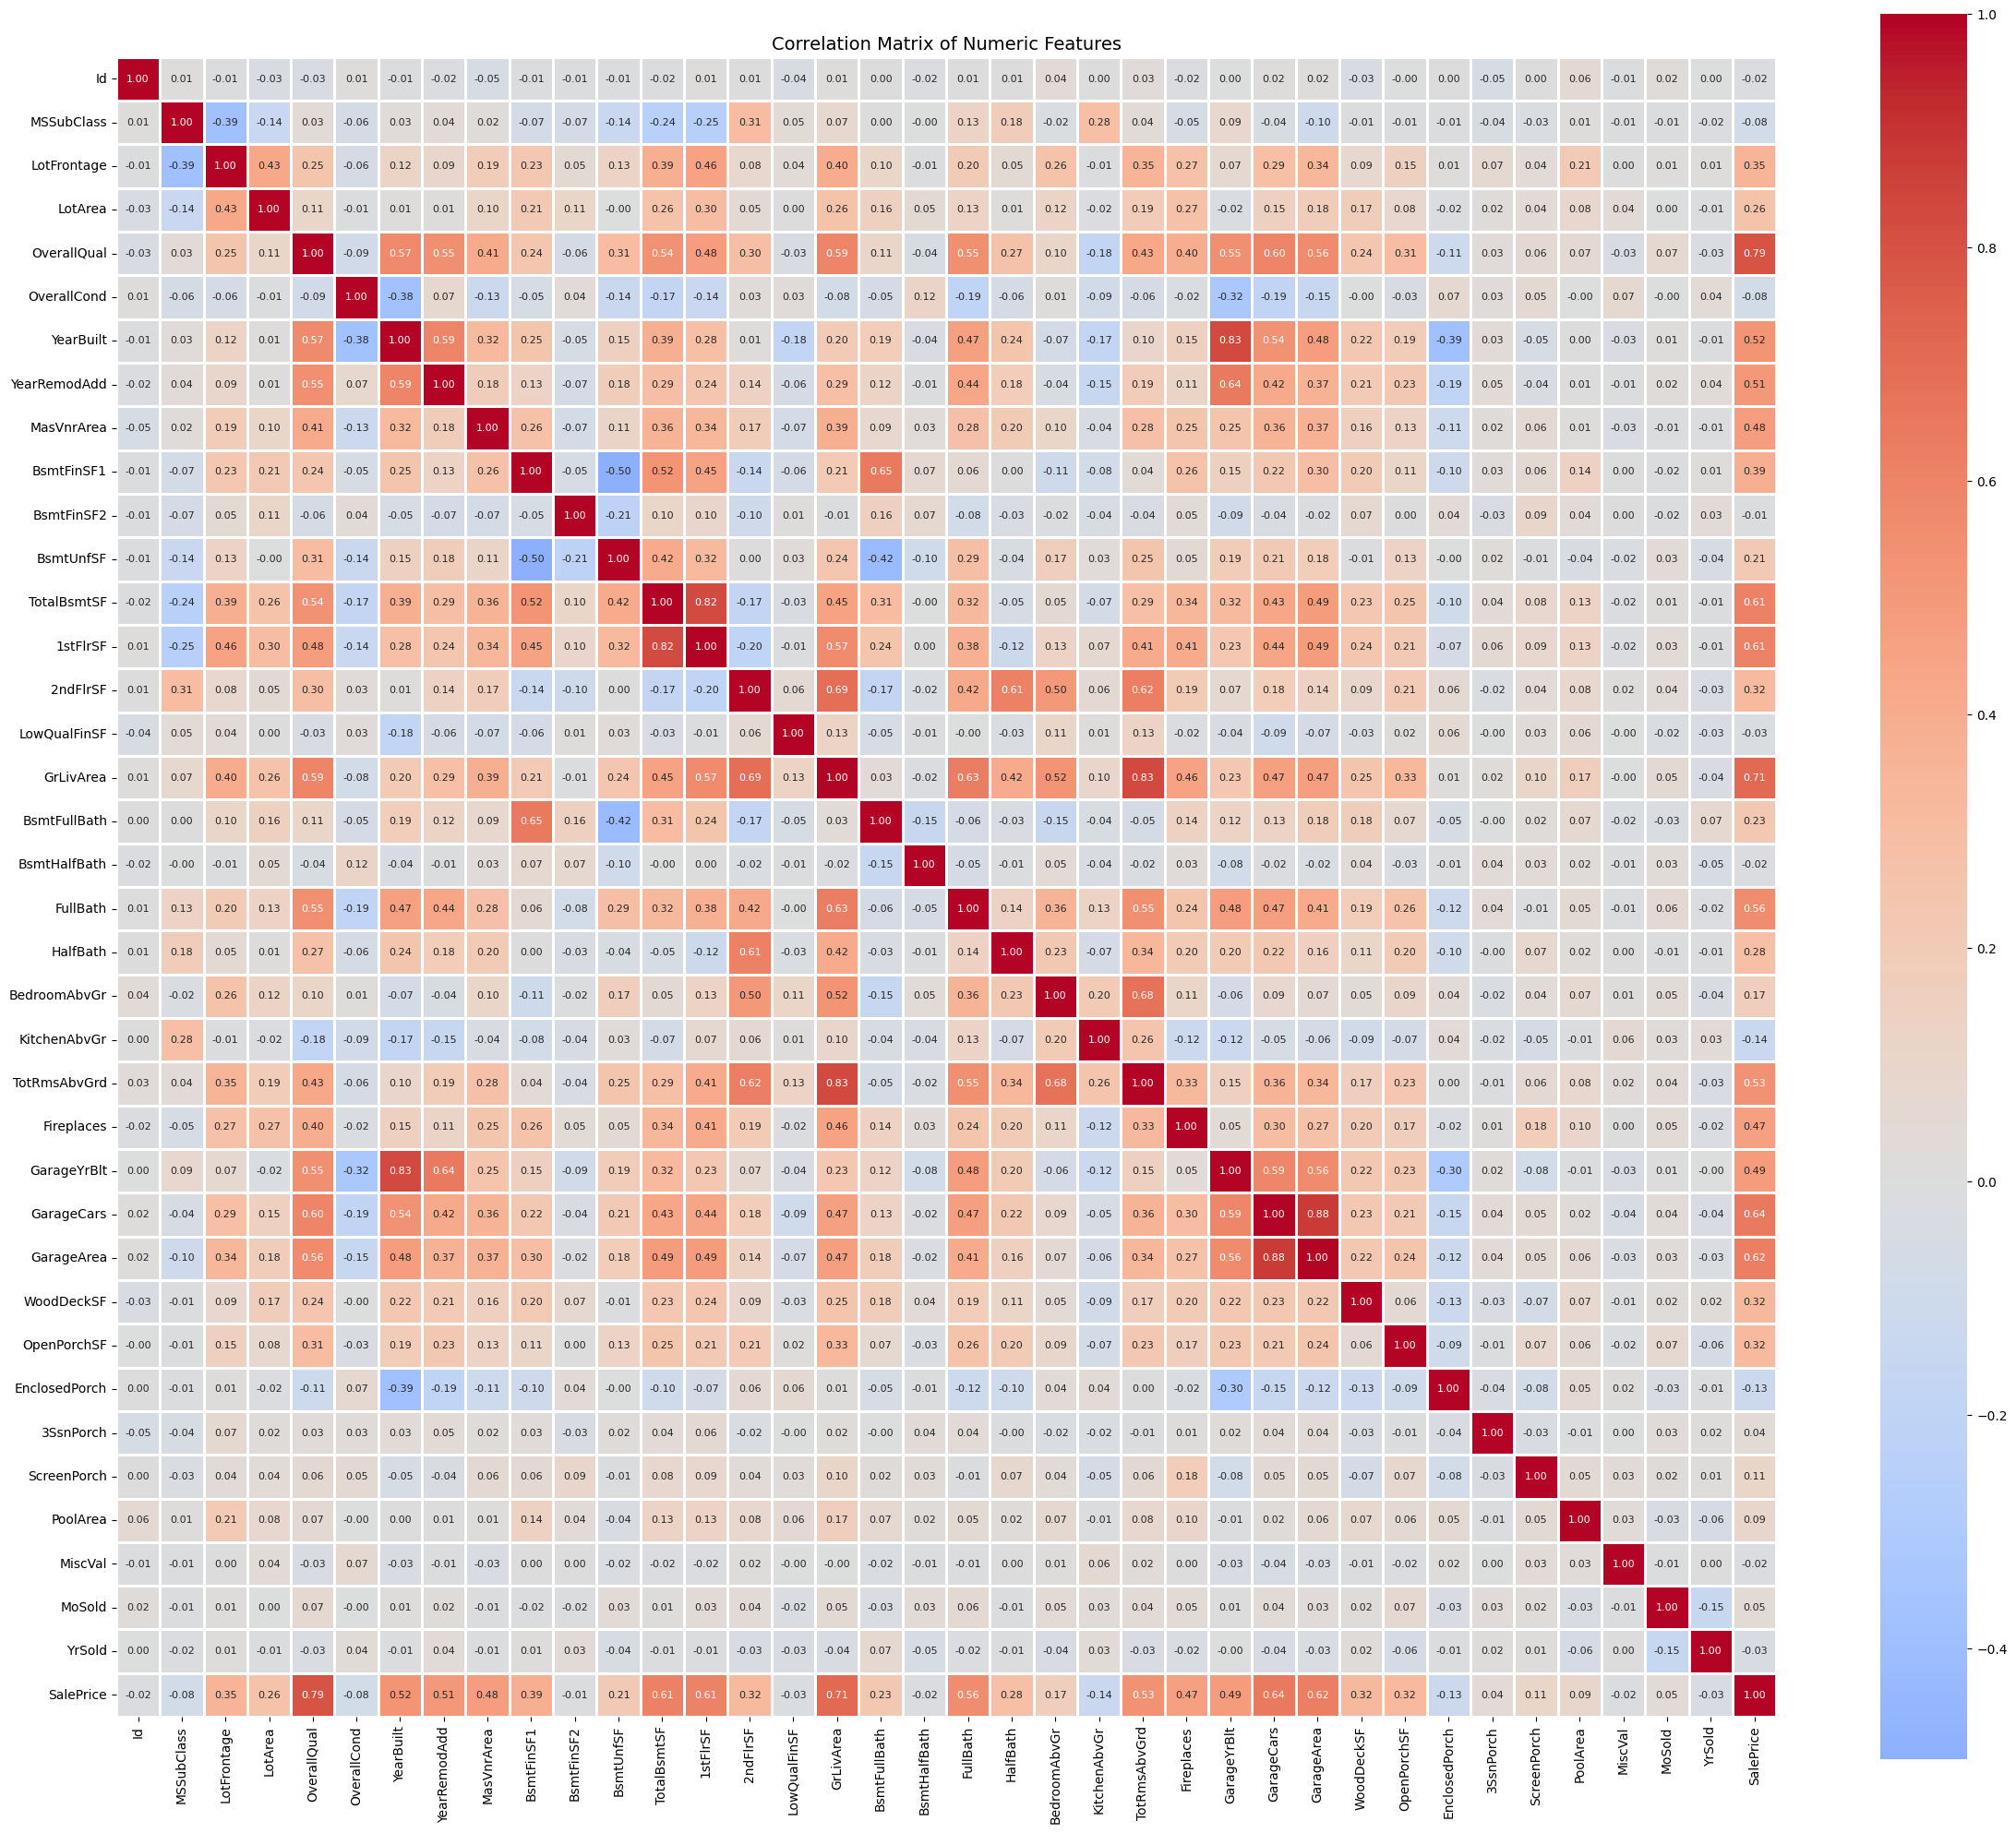

In [37]:
housing_full = housing_raw.copy()
full_square_correlation_matrix(housing_full)

# Plots

## Basic Plots

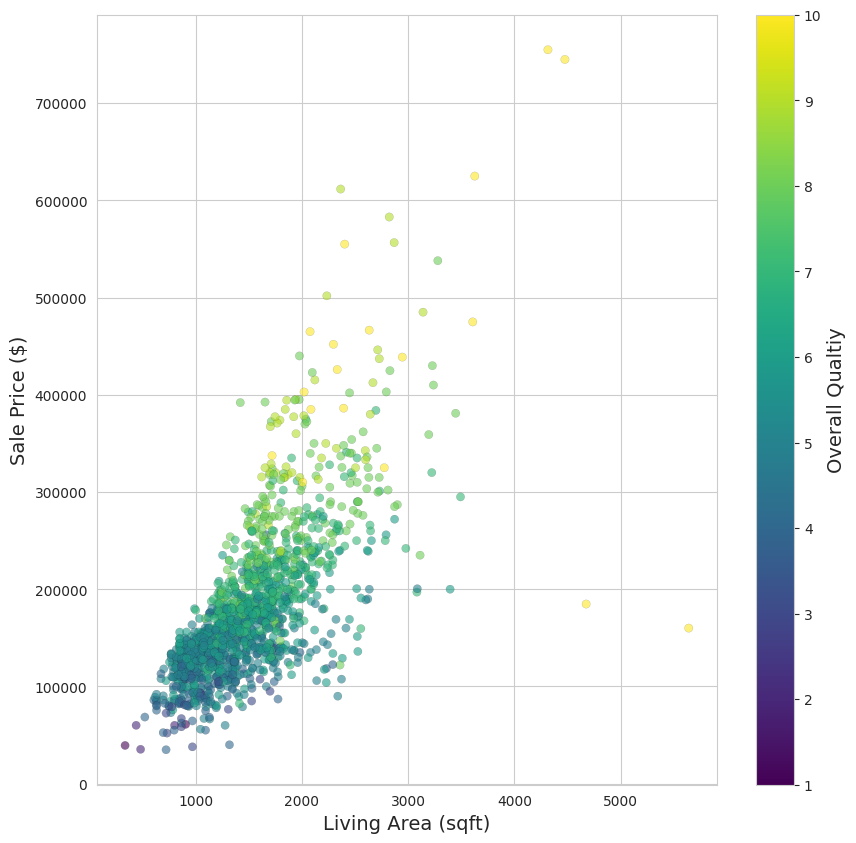

In [ ]:
scatter_plot_colormap(x=cols.GrLivArea, xlabel="Living Area (sqft)", y=cols.SalePrice, ylabel="Sale Price ($)", hue=cols.OverallQual, cbar_title="Overall Qualtiy", )

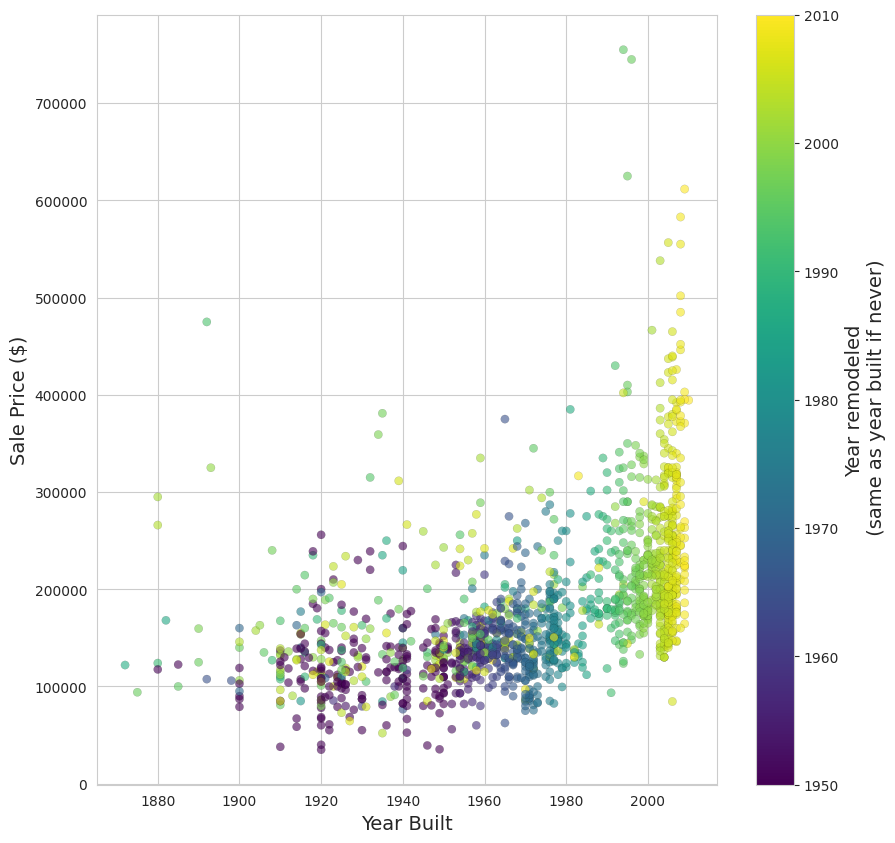

In [ ]:
scatter_plot_colormap(x=cols.YearBuilt, xlabel="Year Built", y=cols.SalePrice, ylabel="Sale Price ($)", hue=cols.YearRemodAdd, cbar_title="Year remodeled\n (same as year built if never)")

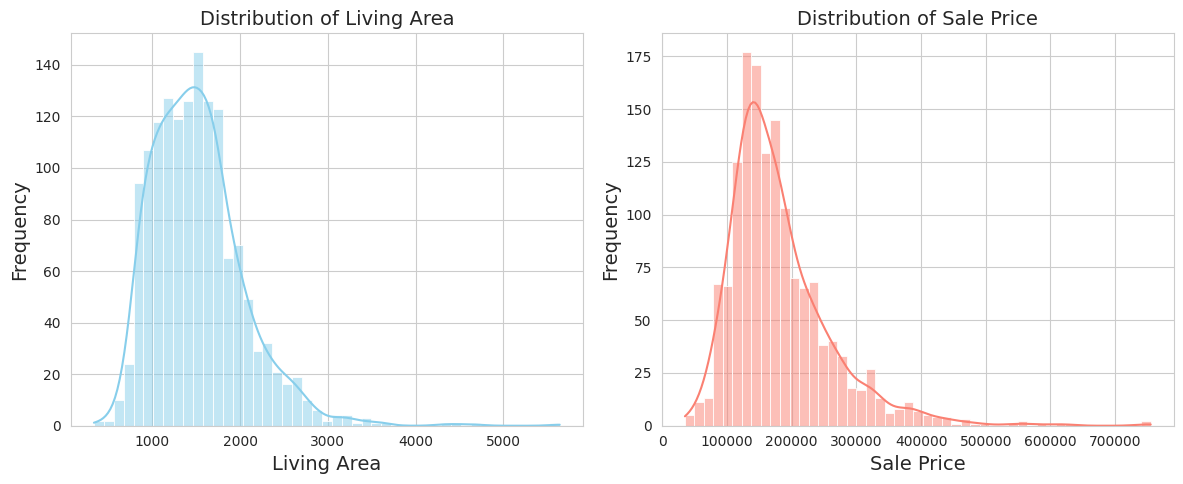

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Distribution of SalePrice
sns.histplot(data=housing_full, x='SalePrice', kde=True, ax=ax1, color='salmon')
ax1.set_xlabel('Sale Price')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sale Price')

# Distribution of GrLivArea
sns.histplot(data=housing_full, x='GrLivArea', kde=True, ax=ax2, color='skyblue')
ax2.set_xlabel('Living Area')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Living Area')



plt.tight_layout()
plt.show()

## Matrix Plots and Correlation

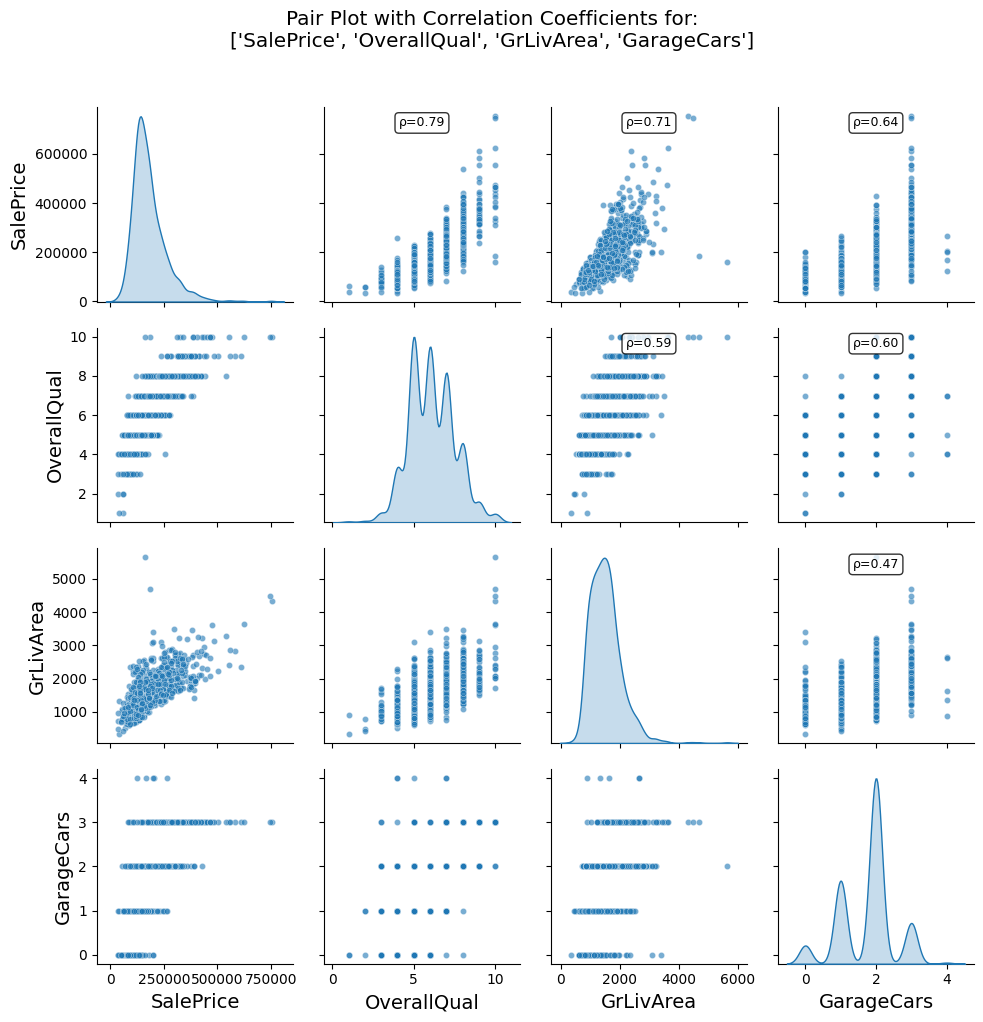

In [ ]:
square_matrix_plots(["SalePrice", "OverallQual", "GrLivArea", "GarageCars"])

    

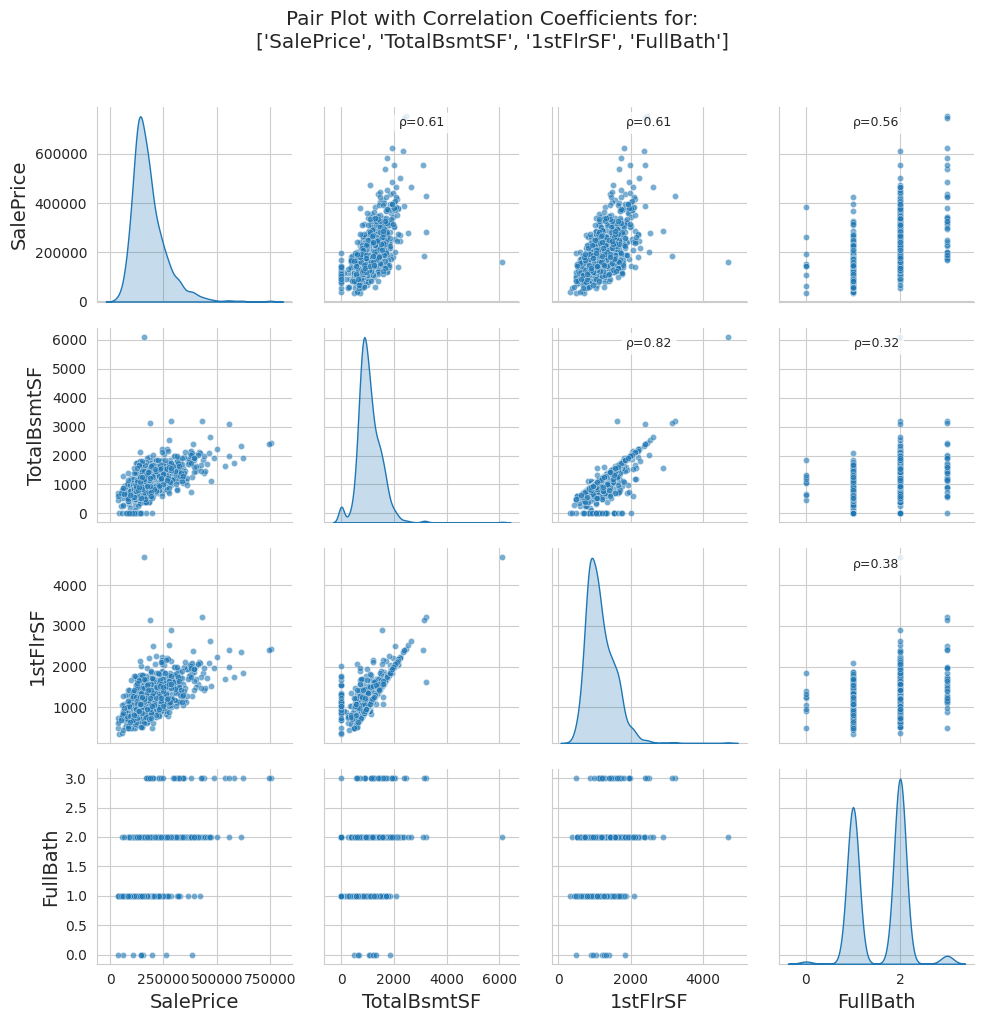

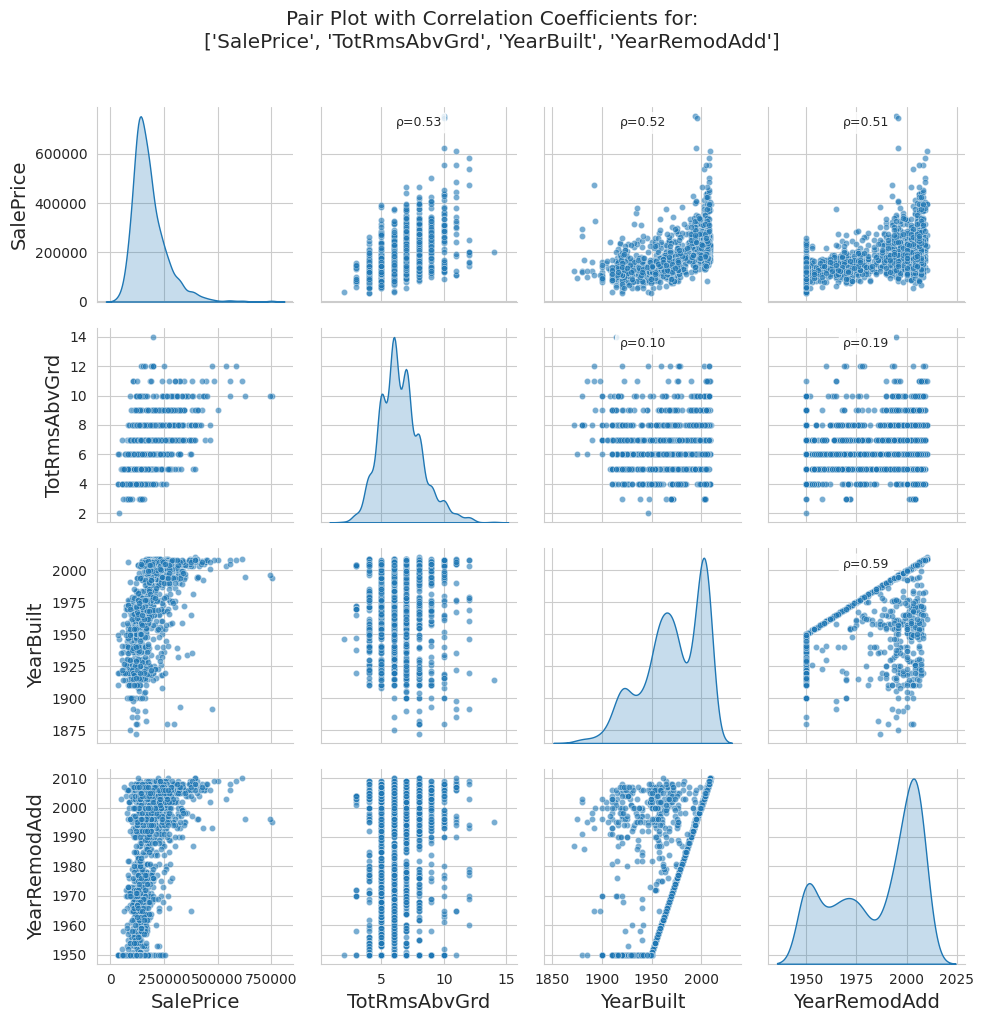

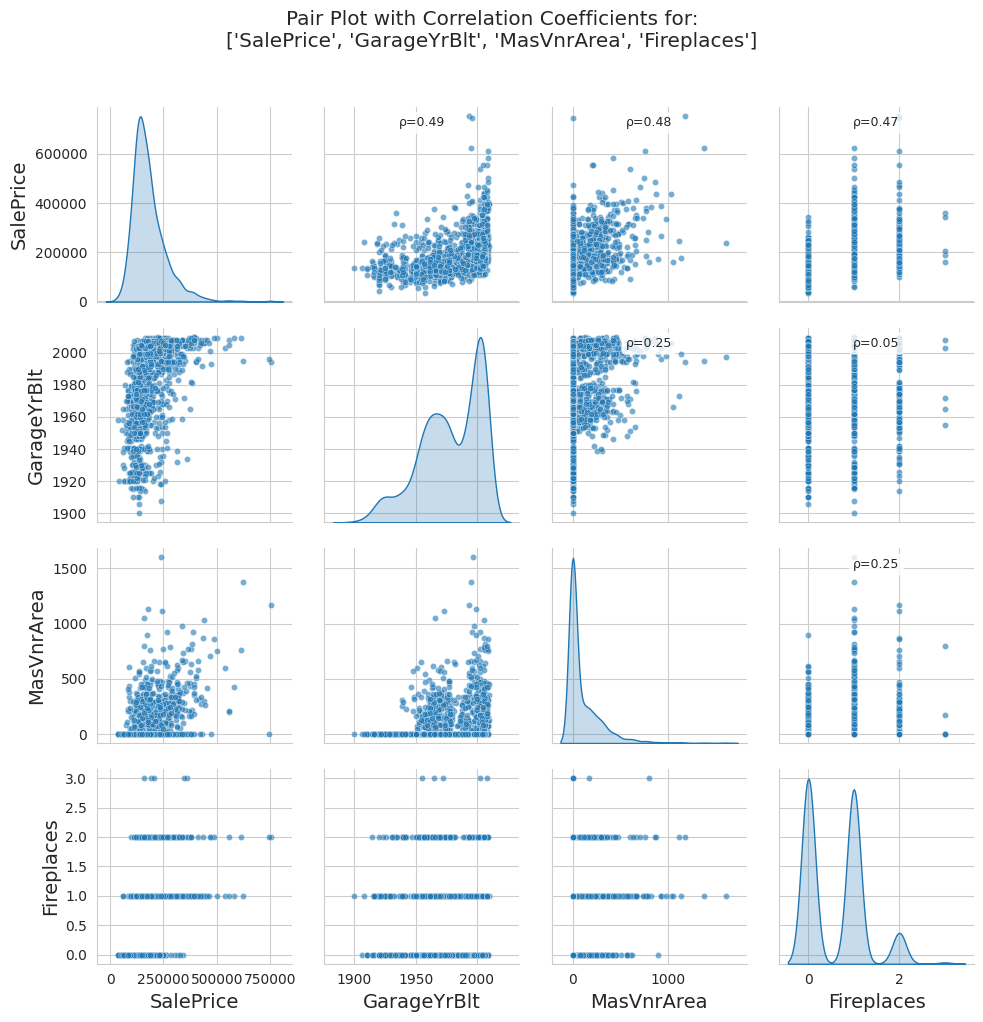

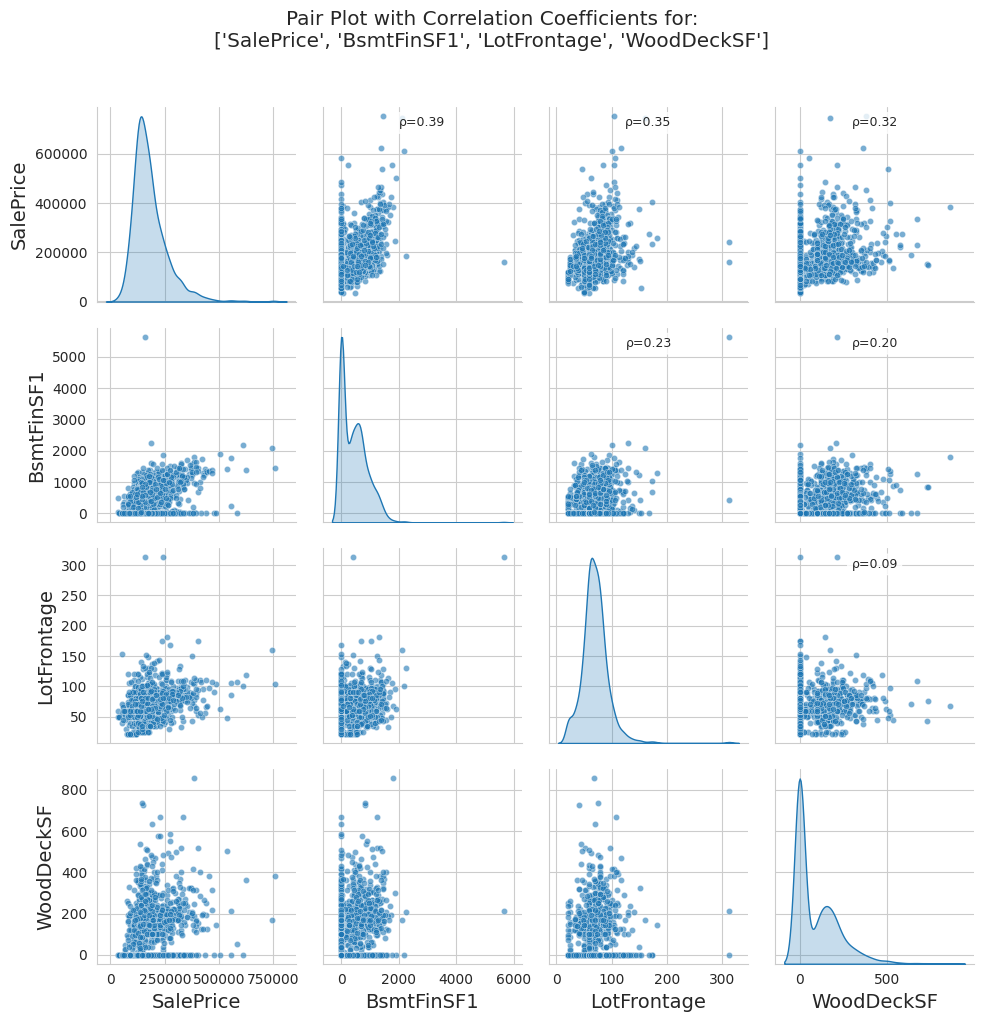

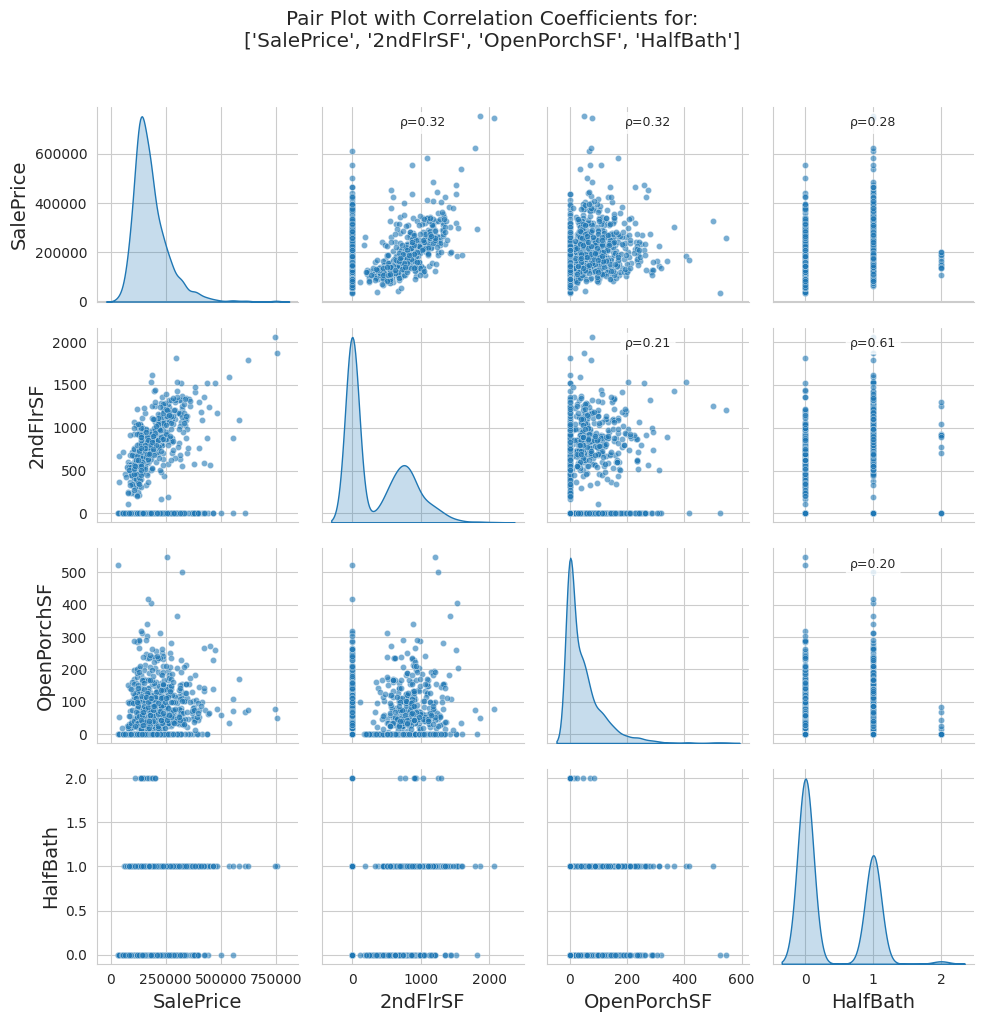

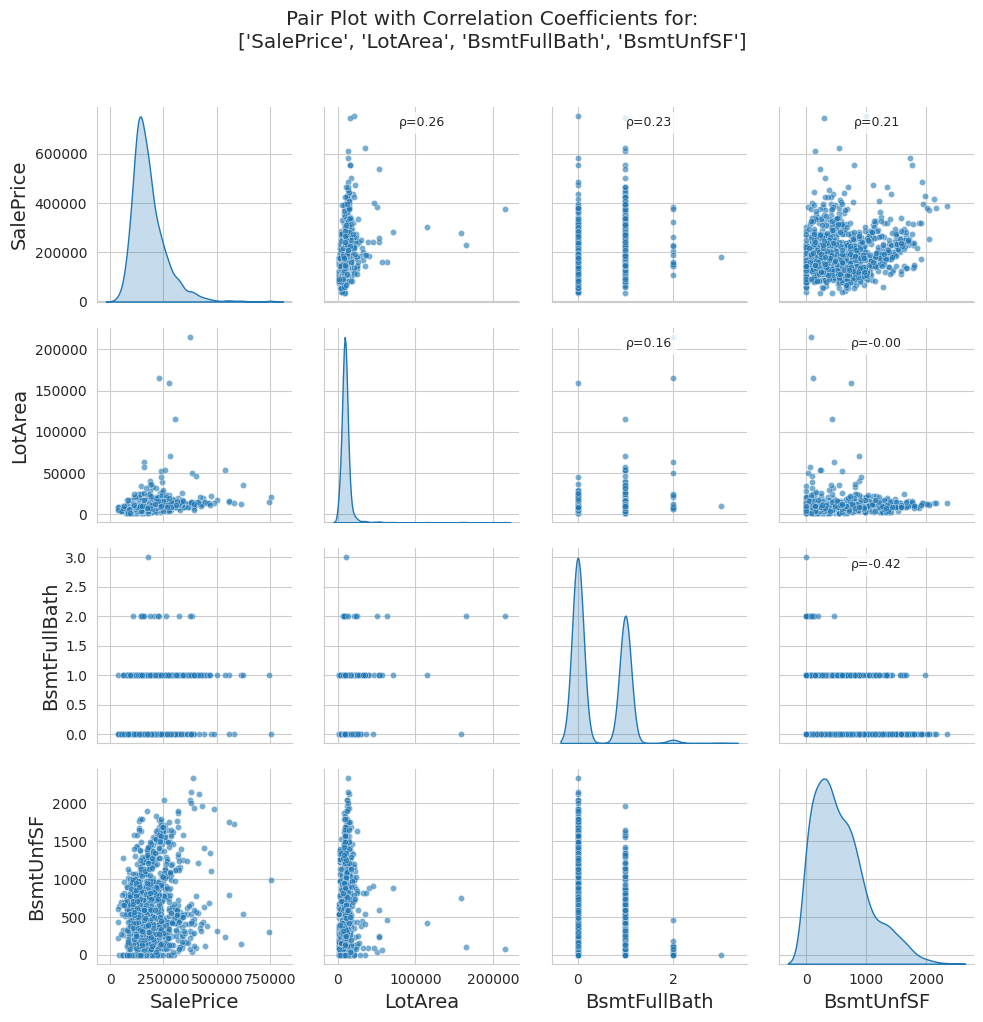

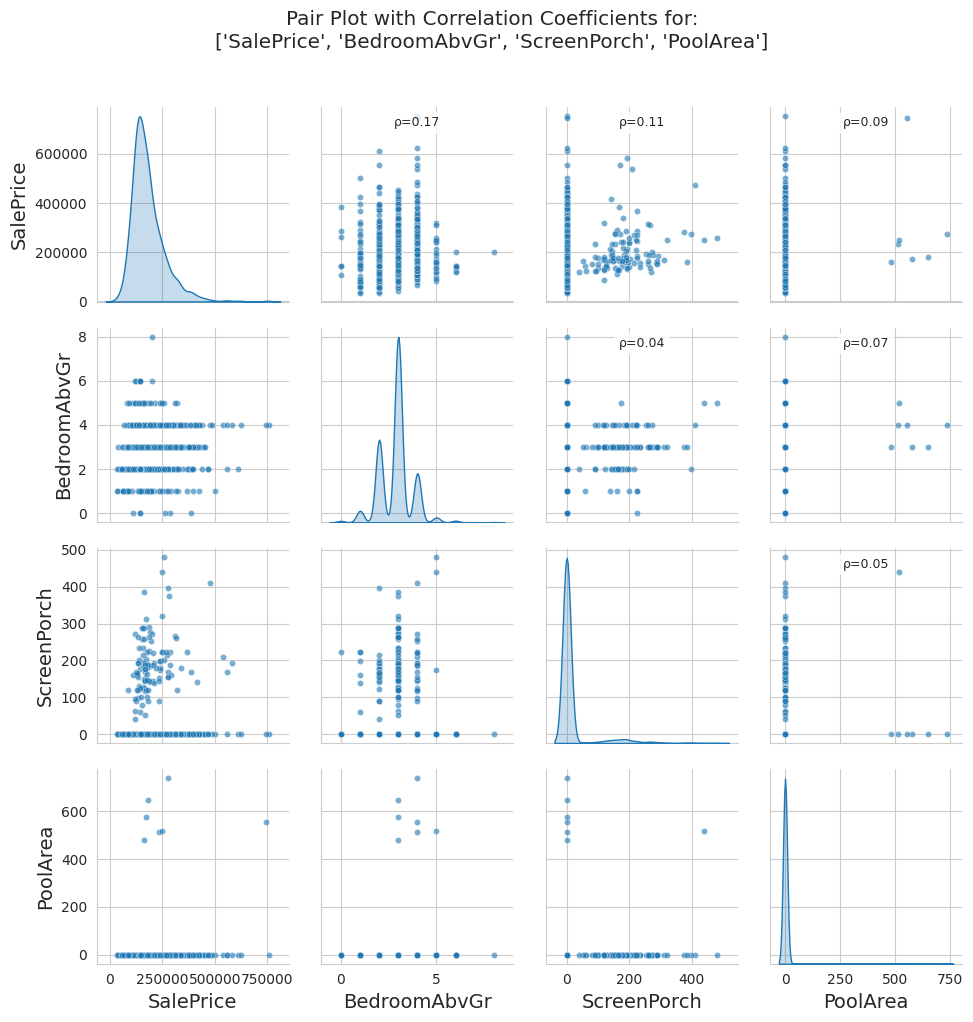

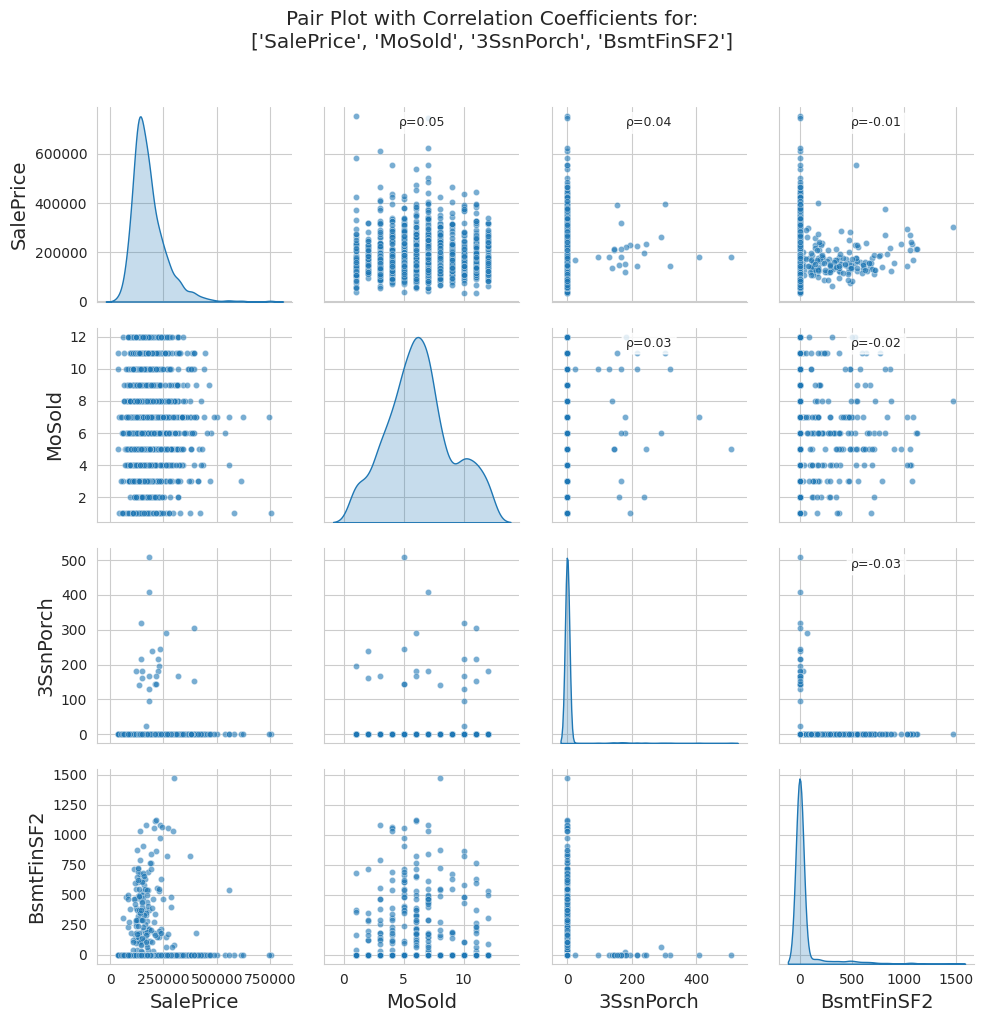

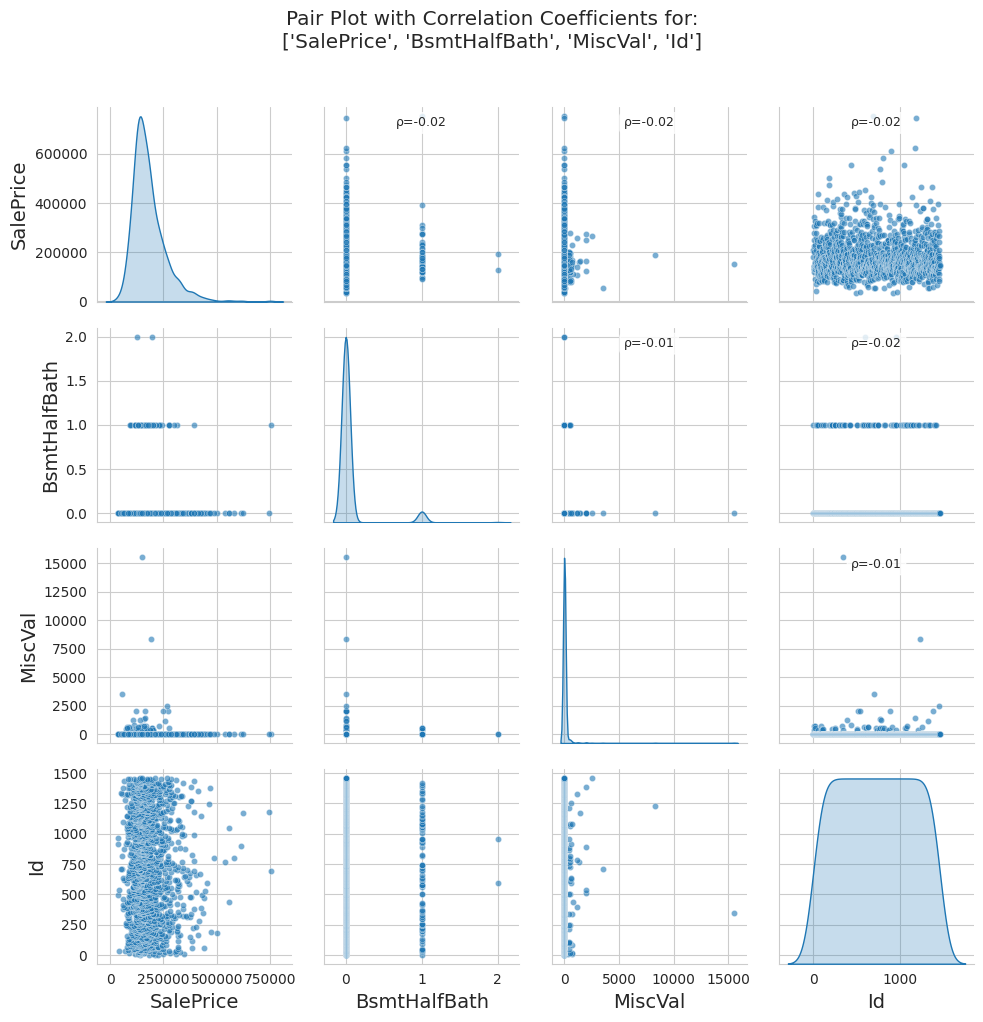

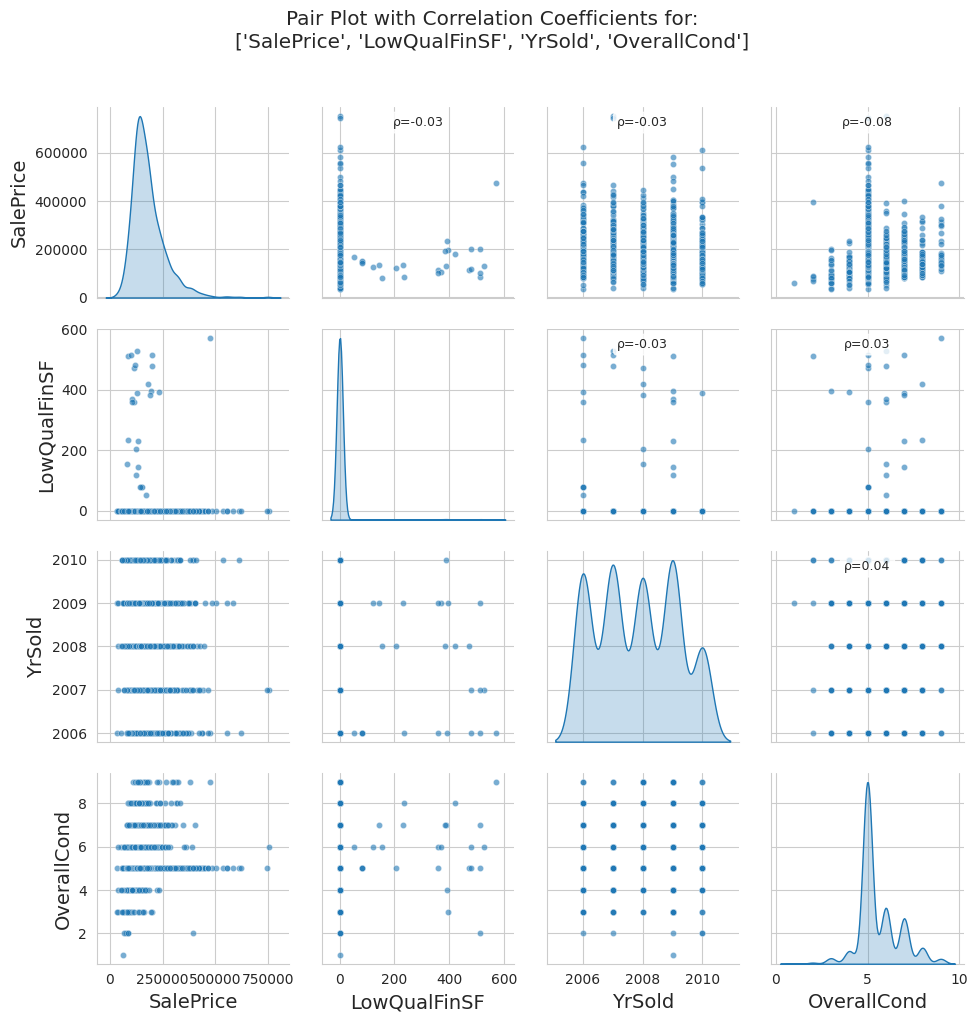

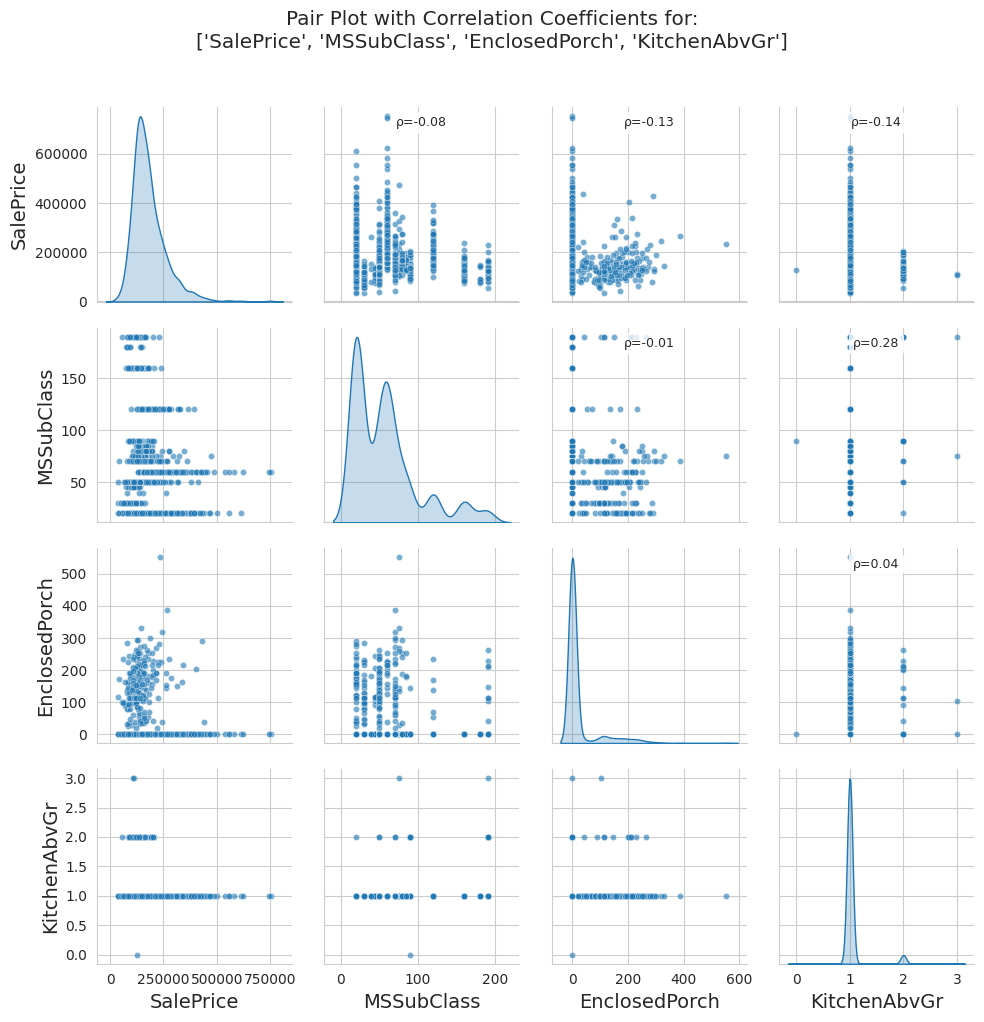

In [ ]:
square_matrix_plots(["SalePrice", "TotalBsmtSF", "1stFlrSF", "FullBath"])
square_matrix_plots(["SalePrice", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd"])
square_matrix_plots(["SalePrice", "GarageYrBlt", "MasVnrArea", "Fireplaces"])
square_matrix_plots(["SalePrice", "BsmtFinSF1", "LotFrontage", "WoodDeckSF"])
square_matrix_plots(["SalePrice", "2ndFlrSF", "OpenPorchSF", "HalfBath"])
square_matrix_plots(["SalePrice", "LotArea", "BsmtFullBath", "BsmtUnfSF"])
square_matrix_plots(["SalePrice", "BedroomAbvGr", "ScreenPorch", "PoolArea"])
square_matrix_plots(["SalePrice", "MoSold", "3SsnPorch", "BsmtFinSF2"])
square_matrix_plots(["SalePrice", "BsmtHalfBath", "MiscVal", "Id"])
square_matrix_plots(["SalePrice", "LowQualFinSF", "YrSold", "OverallCond"])
square_matrix_plots(["SalePrice", "MSSubClass", "EnclosedPorch", "KitchenAbvGr"])

In [ ]:
attributes = ["SalePrice", "TotalBsmtSF", "1stFlrSF", "FullBath"]

scatter_matrix(housing_full[attributes], figsize=(15, 15), grid=True)

plt.show()

# Missing Values

Listing out the features that have missing values:

In [61]:
house_info.columns_with_nan(True)

[('LotFrontage', 259),
 ('Alley', 1369),
 ('MasVnrType', 872),
 ('MasVnrArea', 8),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtExposure', 38),
 ('BsmtFinType1', 37),
 ('BsmtFinType2', 38),
 ('Electrical', 1),
 ('FireplaceQu', 690),
 ('GarageType', 81),
 ('GarageYrBlt', 81),
 ('GarageFinish', 81),
 ('GarageQual', 81),
 ('GarageCond', 81),
 ('PoolQC', 1453),
 ('Fence', 1179),
 ('MiscFeature', 1406)]

From the data description there are a number of features in which NA expliclty means the absence of the thing, for example 'No Pool' or 'No Garage'. 
So they can be thought of as a sort of category of their own.

Here are the columns which contain null values and in which null values are not used to convey this information.

In [ ]:
print(house_info.problematic_columns())
print("\n\tNon-Numerical: ", house_info.problematic_non_num_columns(True))
print("\tNumerical: ", house_info.problematic_num_columns(True))

['LotFrontage', 'MasVnrArea', 'Electrical', 'GarageYrBlt']

	Numerical:  [('Electrical', 1)]
	Non-numerical:  [('LotFrontage', 259), ('MasVnrArea', 8), ('GarageYrBlt', 81)]


In [ ]:
# Assuming 'target' is the column name with NaN values
result = housing_full.loc[
    (df[cols.].isna()) & 
    (df['col3'].notna()) & 
    (df['col4'] > 0),
    ['col2', 'col4', 'col5']
]
print(result)

      SalePrice MasVnrType  MasVnrArea
234      216500        NaN         NaN
529      200624        NaN         NaN
650      205950        NaN         NaN
936      184900        NaN         NaN
973      182000        NaN         NaN
977      199900        NaN         NaN
1243     465000        NaN         NaN
1278     237000        NaN         NaN


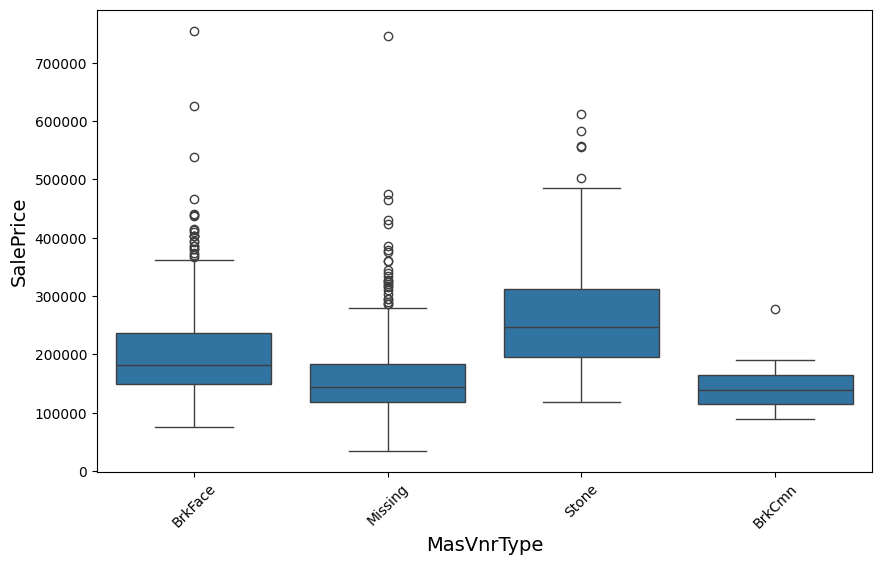

In [64]:
box_plot(cols.MasVnrType)

# Cleaning the Data

Taking care of missing values and outliers

In [15]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageArea  \
0          2003          2003       196.0         706  ...         548   
1          1976          1976         0.0         978  ...         460   
2          2001          2002       162.0         486  ...         608   
3          1915          1970         0.0         216  ...         642   
4          2000          2000       350.0         655  ...         836   
...         ...           ...         ...         ...  ...         ...   
1455       1999          2000         0.0           0  ...         460   
1456       1978          1988       119.0         790  ...         500   
1457       1941          2006         0.0         275  ...         252   
1458       1950          1996         0.0          49  ...         240   
1459       1965          1965         0.0         830  ...         276   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0              0           61              0          0            0   
1            298            0              0          0            0   
2              0           42              0          0            0   
3              0           35            272          0            0   
4            192           84              0          0            0   
...          ...          ...            ...        ...          ...   
1455           0           40              0          0            0   
1456         349            0              0          0            0   
1457           0           60              0          0            0   
1458         366            0            112          0            0   
1459         736           68              0          0            0   

      PoolArea  MiscVal  MoSold  YrSold  
0            0        0       2    2008  
1            0        0       5    2007  
2            0        0       9    2008  
3            0        0       2    2006  
4            0        0      12    2008  
...        ...      ...     ...     ...  
1455         0        0       8    2007  
1456         0        0       2    2010  
1457         0     2500       5    2010  
1458         0        0       4    2010  
1459         0        0       6    2008  

[1460 rows x 37 columns]

In [26]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
imputer.statistics_

array([7.3050e+02, 5.0000e+01, 6.9000e+01, 9.4785e+03, 6.0000e+00,
       5.0000e+00, 1.9730e+03, 1.9940e+03, 0.0000e+00, 3.8350e+02,
       0.0000e+00, 4.7750e+02, 9.9150e+02, 1.0870e+03, 0.0000e+00,
       0.0000e+00, 1.4640e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
       0.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00,
       1.9800e+03, 2.0000e+00, 4.8000e+02, 0.0000e+00, 2.5000e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       6.0000e+00, 2.0080e+03])